In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gymnasium.spaces import MultiDiscrete
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ray.rllib.algorithms.ppo import PPOConfig
from ray.tune.logger import pretty_print
import ray
from src.microgrid_env import MicrogridEnv

2023-10-08 10:45:04,381	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


load data

In [3]:
env_df = pd.read_csv("../data/cropped.csv")
# FIXME: only take some columns that we can experiment
env_df = env_df.iloc[:100]

# names consistent with `update_environment`
env_df = env_df.rename(
  columns={"Wind Speed": "wind_speed",
           "Solar Irradiance": "solar_irradiance",
           "Grid Electricity Price": "rate_consumption_charge"},
)
# compute total energy demand from example houses
env_df["energy_demand"] = env_df["warehouse 1"] + env_df["small hotel 1"]
env_df = env_df.drop(columns=["warehouse 1", "small hotel 1"])
data_dict = env_df.to_dict(orient="list")

setup ray

TODO: we may want to change `pi` in the PPOTorchRLModule from `TorchMLPHead` to
an RNN or something more complex. `PPORLModule`.

In [4]:
ray.shutdown()
ray.init(ignore_reinit_error=True)

2023-10-08 10:45:11,345	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.11.5
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


In [24]:
ray.tune.register_env("foo-v0", lambda _: MicrogridEnv(data_dict))
losses = []
config = PPOConfig().environment(env="foo-v0").training(model={'fcnet_hiddens': [50, 50]})
algo = config.build()

2023-10-08 11:13:51,631	WARNING algorithm_config.py:2578 -- Setting `exploration_config={}` because you set `_enable_rl_module_api=True`. When RLModule API are enabled, exploration_config can not be set. If you want to implement custom exploration behaviour, please modify the `forward_exploration` method of the RLModule at hand. On configs that have a default exploration config, this must be done with `config.exploration_config={}`.
2023-10-08 11:13:51,641	WARNING algorithm_config.py:2578 -- Setting `exploration_config={}` because you set `_enable_rl_module_api=True`. When RLModule API are enabled, exploration_config can not be set. If you want to implement custom exploration behaviour, please modify the `forward_exploration` method of the RLModule at hand. On configs that have a default exploration config, this must be done with `config.exploration_config={}`.
(pid=7394) DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!
(RolloutWork

In [25]:
config.model

{'_disable_preprocessor_api': False,
 '_disable_action_flattening': False,
 'fcnet_hiddens': [50, 50],
 'fcnet_activation': 'tanh',
 'conv_filters': None,
 'conv_activation': 'relu',
 'post_fcnet_hiddens': [],
 'post_fcnet_activation': 'relu',
 'free_log_std': False,
 'no_final_linear': False,
 'vf_share_layers': False,
 'use_lstm': False,
 'max_seq_len': 20,
 'lstm_cell_size': 256,
 'lstm_use_prev_action': False,
 'lstm_use_prev_reward': False,
 '_time_major': False,
 'use_attention': False,
 'attention_num_transformer_units': 1,
 'attention_dim': 64,
 'attention_num_heads': 1,
 'attention_head_dim': 32,
 'attention_memory_inference': 50,
 'attention_memory_training': 50,
 'attention_position_wise_mlp_dim': 32,
 'attention_init_gru_gate_bias': 2.0,
 'attention_use_n_prev_actions': 0,
 'attention_use_n_prev_rewards': 0,
 'framestack': True,
 'dim': 84,
 'grayscale': False,
 'zero_mean': True,
 'custom_model': None,
 'custom_model_config': {},
 'custom_action_dist': None,
 'custom_prepr

In [33]:
for i in range(100):
    print("epoch",i)
    result = algo.train()

    # keep track of statistics
    policy_stats = result["info"]["learner"]["default_policy"]
    print(pretty_print(policy_stats))
    losses.append(policy_stats["total_loss"])

    # if i % 5 == 0:
    #     checkpoint_dir = algo.save().checkpoint.path
    #     print(f"Checkpoint saved in directory {checkpoint_dir}")

epoch 0
curr_entropy_coeff: 0.0
curr_kl_coeff: 0.675000011920929
curr_lr: 5.0e-05
default_optimizer_lr: 5.000000000000001e-05
entropy: 21.676442101566014
mean_kl_loss: 0.013561839965280832
policy_loss: -0.012698147100394469
total_loss: 9.996456095404717
vf_explained_var: -6.415569451826213e-06
vf_loss: 10.0
vf_loss_unclipped: 147978992607.24948

epoch 1
curr_entropy_coeff: 0.0
curr_kl_coeff: 0.675000011920929
curr_lr: 5.0e-05
default_optimizer_lr: 5.000000000000001e-05
entropy: 21.510193790199914
mean_kl_loss: 0.012054093382982495
policy_loss: -0.009215220887420465
total_loss: 9.998921281493296
vf_explained_var: -6.42840542010407e-06
vf_loss: 10.0
vf_loss_unclipped: 144250168868.02557

epoch 2
curr_entropy_coeff: 0.0
curr_kl_coeff: 0.675000011920929
curr_lr: 5.0e-05
default_optimizer_lr: 5.000000000000001e-05
entropy: 21.61477373505452
mean_kl_loss: 0.013745497744480174
policy_loss: -0.013474366984574366
total_loss: 9.995803850291889
vf_explained_var: -6.543420779425452e-06
vf_loss: 10

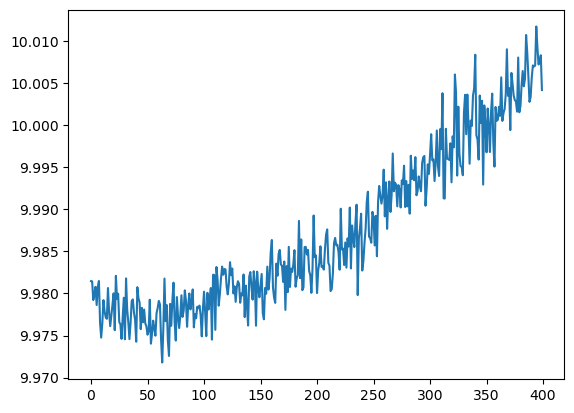

In [34]:
plt.plot(losses);